<a href="https://colab.research.google.com/github/5ahar-K/Project/blob/main/Outage3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.special import kv, gamma
from scipy.integrate import cumulative_trapezoid
import math # Import the standard math module

# ----------------------------
# 1) h_ul = exp(-zeta1 * Z)
# ----------------------------
def sample_hul(Z, zeta1):
    return np.exp(-zeta1 * Z)

# ----------------------------
# 2) Málaga PDF f_hua(h)
#    Eq. (3) in the paper
#    NOTE: This form uses a finite sum m=1..beta, so beta should be an integer.
# ----------------------------
def malaga_pdf(h, alpha, beta, g, Omega):
    """
    Málaga(M) irradiance PDF from Eq. (3) in the PDF.
    Parameters:
      alpha, beta : large/small scale parameters (beta should be integer for this finite-sum form)
      g, Omega    : Málaga parameters (see paper's Table I context)
    """
    h = np.asarray(h)
    h = np.maximum(h, 1e-300)  # avoid 0 in power terms

    # A_M const(Eq 3, Comprehensive Paper)
    AM = (2 * (alpha**(alpha/2.0)) / (g**(1 + alpha/2.0) * gamma(alpha))) * \
         ((g*beta / (g*beta + Omega))**(beta + alpha/2.0))

    out = np.zeros_like(h, dtype=float)

    # finite sum m=1..beta (assumes beta is integer)
    beta_int = int(beta)
    if beta_int != beta:
        raise ValueError("This Málaga PDF implementation assumes beta is an integer (finite sum m=1..beta).")

    for m in range(1, beta_int + 1):
        # a_m (paper's Eq. (3) description)
        am = (math.comb(beta_int - 1, m - 1) * # Corrected: use math.comb
              (g*beta + Omega)**(1 - m/2.0) / math.factorial(m - 1) * # Corrected: use math.factorial
              (Omega / g)**(m - 1) *
              (alpha / beta)**(m/2.0))

        nu = alpha - m
        arg = 2.0 * np.sqrt(alpha * beta * h / (g*beta + Omega))

        out += am * (h**((alpha + m)/2.0 - 1.0)) * kv(nu, arg)

    return AM * out

# ----------------------------
# 3) Sample Málaga via numerical inverse-CDF
# ----------------------------
def sample_malaga(alpha, beta, g, Omega, size=1, h_max=50.0, grid_n=200000, rng=None):
    """
    Draw samples from Málaga(M) by building a numerical CDF on [0, h_max]
    and inverting it.

    Tips:
      - Increase h_max if you expect very heavy tails.
      - Increase grid_n for more accuracy (slower).
    """
    if rng is None:
        rng = np.random.default_rng()

    # Build grid
    h_grid = np.linspace(0.0, h_max, grid_n)
    # avoid h=0 exactly for stability in pdf
    h_grid[0] = 1e-12

    pdf = malaga_pdf(h_grid, alpha, beta, g, Omega)
    # Normalize numerically in case of truncation at h_max
    cdf = cumulative_trapezoid(pdf, h_grid, initial=0.0)
    cdf /= cdf[-1]  # normalize so last value is 1

    # Inverse-CDF sampling
    u = rng.random(size)
    samples = np.interp(u, cdf, h_grid)
    return samples

# ----------------------------
# 4) Sample h1 = h_ul * h_ua
# ----------------------------
def sample_h1(Z, zeta1, alpha, beta, g, Omega, size=1, rng=None,
              h_max=50.0, grid_n=200000):
    hul = sample_hul(Z, zeta1)  # scalar
    hua = sample_malaga(alpha, beta, g, Omega, size=size, rng=rng,
                        h_max=h_max, grid_n=grid_n)
    return hul * hua
def one_trial_outage(Pt, params, rng, gamma_th_dB=5.0):
    """
    Outage if:
      (a) AoA interruption (spot outside array), OR
      (b) instantaneous SNR < gamma_th
    """
    Na      = params["Na"]
    wa      = params["wa"]
    wf      = params["wf"]
    fc      = params["fc"]
    sigma_I = params["sigma_I"]
    sigma_x = params["sigma_x"]
    sigma_y = params["sigma_y"]
    mu      = params["mu"]
    sigma_s = params["sigma_s"]
    sigma0  = params["sigma0"]

    theta_x = rng.normal(0.0, sigma_x)
    theta_y = rng.normal(0.0, sigma_y)

    h2s, interrupted = h2_scalar_and_interrupt(
        theta_x, theta_y, Na, wa, wf, fc, sigma_I
    )
    if interrupted:
        return 1  # outage

    gamma_th = 10**(gamma_th_dB / 10.0)

    mean = mu * Pt * h2s
    var  = (sigma_s**2) * (Pt * h2s) + sigma0**2
    gamma = (mean**2) / var

    return int(gamma < gamma_th)

    # --- h1 draw (atmospheric attenuation + turbulence)
    Z     = h1_params["Z"]
    zeta1 = h1_params["zeta1"]
    alpha = h1_params["alpha"]
    beta  = h1_params["beta"]
    g     = h1_params["g"]
    Omega = h1_params["Omega"]
    h_max = h1_params.get("h_max", 100.0)
    grid_n= h1_params.get("grid_n", 300000)

    h1 = float(sample_h1(Z, zeta1, alpha, beta, g, Omega, size=1, rng=rng,
                         h_max=h_max, grid_n=grid_n)[0])

    # --- total gain
    h = h1 * h2s

    # --- instantaneous SNR for OOK '1' symbol
    mean = mu * Pt * h
    var  = (sigma_s**2) * (Pt * h) + sigma0**2
    gamma = (mean**2) / var

    return (gamma < gamma_th_lin)




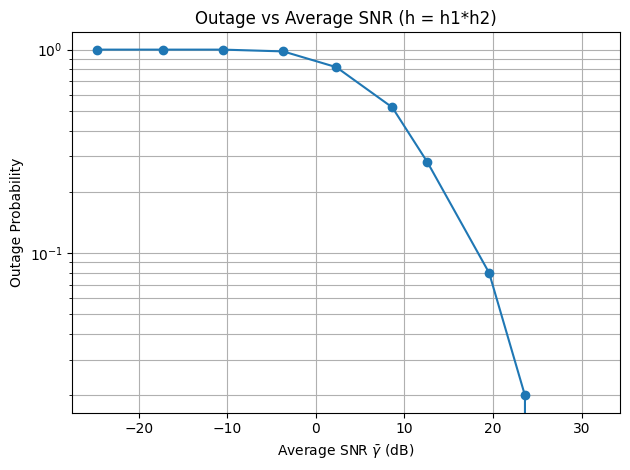

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# ======================
# Your h2 functions
# ======================
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2.0))

def compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I):
    w_prime = wa + wf
    x0 = fc * theta_x
    y0 = fc * theta_y

    i = np.arange(Na)
    j = np.arange(Na)

    x_left  = (i - 1 - Na/2) * w_prime + wf/2
    x_right = (i     - Na/2) * w_prime - wf/2
    ax1 = (x_left  - x0) / sigma_I
    ax2 = (x_right - x0) / sigma_I
    px = Q(ax1) - Q(ax2)

    y_bottom = (j - 1 - Na/2) * w_prime + wf/2
    y_top    = (j     - Na/2) * w_prime - wf/2
    ay1 = (y_bottom - y0) / sigma_I
    ay2 = (y_top    - y0) / sigma_I
    py = Q(ay1) - Q(ay2)

    h2 = px[:, None] * py[None, :]
    s = np.sum(h2)
    if s > 0:
        h2 /= s
    return h2

def h2_scalar_and_interrupt(theta_x, theta_y, Na, wa, wf, fc, sigma_I):
    w_prime = wa + wf
    r_array = (Na * w_prime) / 2.0

    x0 = fc * theta_x
    y0 = fc * theta_y
    r_d = np.sqrt(x0**2 + y0**2)

    if r_d > r_array:
        return 0.0, True

    h2 = compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I)
    return float(np.max(h2)), False

# ---- You already have these from your h1 code:
# sample_hul, malaga_pdf, sample_malaga, sample_h1

def snr_inst(Pt, h, mu, sigma_s, sigma0):
    mean = mu * Pt * h
    var  = (sigma_s**2) * (Pt * h) + sigma0**2
    return (mean**2) / var

def outage_curve_h1h2_vs_avgSNR(
    Pt_list,
    n_trials,
    rng,
    # h2 params
    Na, wa, wf, fc, sigma_I, sigma_x, sigma_y,
    # h1 params
    Z, zeta1, alpha, beta, g, Omega,
    h_max=120.0, grid_n=250000,
    # receiver params
    mu=1.0, sigma_s=0.01, sigma0=0.001,
    # outage threshold
    gamma_th_dB=5.0
):
    gamma_th = 10**(gamma_th_dB / 10.0)

    avg_snr_dB = []
    pout = []

    for Pt in Pt_list:
        gammas = []
        out_count = 0


        for _ in range(n_trials):
            theta_x = rng.normal(0.0, sigma_x)
            theta_y = rng.normal(0.0, sigma_y)

            h2s, interrupted = h2_scalar_and_interrupt(theta_x, theta_y, Na, wa, wf, fc, sigma_I)
            if interrupted:
                out_count += 1
                continue

            h1 = float(sample_h1(Z, zeta1, alpha, beta, g, Omega,
                                 size=1, rng=rng, h_max=h_max, grid_n=grid_n)[0])

            h = h1 * h2s
            gamma = snr_inst(Pt, h, mu, sigma_s, sigma0)
            gammas.append(gamma)
            out_count += int(gamma < gamma_th)

        gammas = np.array(gammas) if len(gammas) > 0 else np.array([0.0])
        avg_snr_dB.append(10*np.log10(np.mean(gammas)))
        pout.append(out_count / n_trials)

    return np.array(avg_snr_dB), np.array(pout)

if __name__ == "__main__":
    rng = np.random.default_rng(1234)

    Pt_dB_list = np.linspace(-45, -10, 11)     # dBW
    Pt_list = 10**(Pt_dB_list/10.0)            # W

    # ---- h2 params
    Na = 2
    wa = 2e-3
    wf = 0.0
    fc = 0.05
    sigma_I = 100e-6
    sigma_x = 5e-3
    sigma_y = 5e-3

    # ---- h1 params (paper-consistent block)
    Z = 250.0
    zeta1 = (np.log(10)/10.0) * (0.43/1000.0)
    alpha = 2.1
    beta  = 3
    Omega = 1.3265
    rho   = 0.596
    b0    = 0.1079
    g     = 2*b0*(1-rho)

    # ---- receiver params
    mu = 1.0
    sigma_s = 0.01
    sigma0  = 0.001

    avgSNR_dB, Pout = outage_curve_h1h2_vs_avgSNR(
        Pt_list=Pt_list,
        n_trials=50,
        rng=rng,
        Na=Na, wa=wa, wf=wf, fc=fc, sigma_I=sigma_I, sigma_x=sigma_x, sigma_y=sigma_y,
        Z=Z, zeta1=zeta1, alpha=alpha, beta=beta, g=g, Omega=Omega,
        mu=mu, sigma_s=sigma_s, sigma0=sigma0,
        gamma_th_dB=5.0
    )

    plt.figure()
    plt.semilogy(avgSNR_dB, Pout, marker="o")
    plt.grid(True, which="both")
    plt.xlabel("Average SNR $\\bar{\\gamma}$ (dB)")
    plt.ylabel("Outage Probability")
    plt.title("Outage vs Average SNR (h = h1*h2)")
    plt.tight_layout()
    plt.show()
